# Rainforest Connection Species Audio Detection (音声データ拡張編)

本ノートブックは、主にPythonや機械学習を初めて音声分類について学びたい方むけに、[「Rainforest Connection Species Audio Detection」](https://www.kaggle.com/c/rfcx-species-audio-detection)を題材にスクリプトを作成しました。チュートリアル形式なのでぜひ皆様に手を動かしてもらい、一緒に学んでいきましょう！

本チュートリアルでは、採用した方針やそれぞれの手法の論理については説明を省きますが、詳しく知りたい方は[【実装】機械学習で森の生き物を守る？](https://)をぜひ読んでみてください。

ただスクリプトを参考にするのではなく、何が行われているのかを実際に理解すると、他のカグルのコンペや、機械学習の問題を自分の力で解けるようになると思います！

In [1]:
#インポート
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
import multiprocessing as mm
from IPython.display import Audio
import glob
import os
import joblib
import h5py
from tqdm import tqdm
from IPython.display import Audio
import librosa.display

## 音声表示、波形プロット、メルスペクトログラム

In [2]:
flacfiles = glob.glob("train/*.flac")

In [3]:
waveform, sr = lb.load(flacfiles[0])

In [4]:
Audio(waveform, rate=sr)

In [5]:
sr

22050

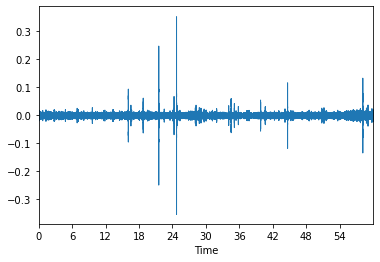

In [6]:
lb.display.waveplot(waveform, sr=sr)

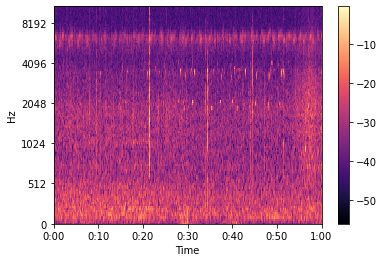

In [7]:
melspec = lb.power_to_db(lb.feature.melspectrogram(waveform, sr=32000, n_mels=128, fmin = 0, fmax = 9000))
lb.display.specshow(melspec, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar();

## データ拡張処理

In [8]:
# 確率的に処理を施すクラス
class TransformWaveform:
    def __init__(self, always_apply=False, prob=0.5):
        self.always_apply = always_apply
        self.prob = prob

    def __call__(self, y: np.ndarray):
        if self.always_apply:
            return self.apply(y)
        else:
            if np.random.rand() < self.prob:
                return self.apply(y)
            else:
                return y

    def apply(self, y: np.ndarray):
        raise NotImplementedError

# 複数の処理をまとめるクラス
class Multiple:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y

In [9]:
# リサンプリング
class ResampleWaveform(TransformWaveform):
    def __init__(self, always_apply=True, prob=0.5, sr=sr):
        super().__init__(always_apply, prob)
        self.sr = sr
        
    def apply(self, y: np.ndarray, **params):
        y_resampled = lb.resample(y, self.sr, 32000)
        return y_resampled

In [10]:
# ホワイトノイズ
class GaussianNoiseSNR(TransformWaveform):
    def __init__(self, always_apply=True, p=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
        super().__init__(always_apply, prob)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise ** 2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented

In [11]:
# ピンクノイズ
import colorednoise as cn
class PinkNoiseSNR(TransformWaveform):
    def __init__(self, always_apply=False, prob=0.5, min_snr=5.0, max_snr=20.0, **kwargs):
        super().__init__(always_apply, prob)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise ** 2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented

In [12]:
# ピッチシフト
class PitchShift(TransformWaveform):
    def __init__(self, always_apply=False, p=0.5, max_steps=5, sr=32000):
        super().__init__(always_apply, p)

        self.max_steps = max_steps
        self.sr = sr

    def apply(self, y: np.ndarray, **params):
        n_steps = np.random.randint(-self.max_steps, self.max_steps)
        augmented = librosa.effects.pitch_shift(y, sr=self.sr, n_steps=n_steps)
        return augmented

In [13]:
# タイムシフト
class TimeShift(TransformWaveform):
    def __init__(self, always_apply=False, p=0.5, max_shift_second=2, sr=32000, padding_mode="replace"):
        super().__init__(always_apply, p)
    
        assert padding_mode in ["replace", "zero"], "`padding_mode` must be either 'replace' or 'zero'"
        self.max_shift_second = max_shift_second
        self.sr = sr
        self.padding_mode = padding_mode

    def apply(self, y: np.ndarray, **params):
        shift = np.random.randint(-self.sr * self.max_shift_second, self.sr * self.max_shift_second)
        augmented = np.roll(y, shift)
        if self.padding_mode == "zero":
            if shift > 0:
                augmented[:shift] = 0
            else:
                augmented[shift:] = 0
        return augmented

In [14]:
#　音量
class VolumeShift(TransformWaveform):
    def __init__(self, always_apply=False, p=0.5, db_limit=10, mode="cosine"):
        super().__init__(always_apply, p)

        assert mode in ["uniform", "fade", "fade", "cosine", "sine"], \
            "`mode` must be one of 'uniform', 'fade', 'cosine', 'sine'"

        self.db_limit= db_limit
        self.mode = mode

    def apply(self, y: np.ndarray, **params):
        db = np.random.uniform(-self.db_limit, self.db_limit)
        if self.mode == "uniform":
            db_translated = 10 ** (db / 20)
        elif self.mode == "fade":
            lin = np.arange(len(y))[::-1] / (len(y) - 1)
            db_translated = 10 ** (db * lin / 20)
        elif self.mode == "cosine":
            cosine = np.cos(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * cosine / 20)
        else:
            sine = np.sin(np.arange(len(y)) / len(y) * np.pi * 2)
            db_translated = 10 ** (db * sine / 20)
        augmented = y * db_translated
        return augmented

## データ拡張して保存

In [1]:
#使うCPUの数と、npyファイルの出力先
num_CPU = mm.cpu_count() - 1
new_dir = 'npy_files'
output_train= 'npy_files/train'
output_test= 'npy_files/test'

NameError: name 'mm' is not defined

In [16]:
# メルスペクトログラムのパラメータ
class melparams:
    sr = 32000
    n_mels = 128
    fmin = 0
    fmax = 10000

In [17]:
# 複数の音声処理の関数
transform = Multiple([
    GaussianNoiseSNR(min_snr=15, max_snr=30),
    PinkNoiseSNR(min_snr=8, max_snr=30),
    PitchShift(max_steps=2, sr=sr),
    TimeShift(sr=sr),
    VolumeShift(mode="cosine")
])

In [18]:
def compute_melspec(y, melparams):
    melspec = lb.power_to_db(lb.feature.melspectrogram(y, *melparams), 2).astype(np.float32)
    return melspec

In [19]:
def load_and_save(record, out_dir):
    y, _ = lb.load(record)
    y_augmented = transform(y)
    melspec = compute_melspec(y, melparams)
    melspec_augmented = compute_melspec(y_augmented, melparams)
    
    record_name = '0' + record.split('/')[-1].replace('.flac', '.npy')
    augmented_record_name = '1' + record_name.replace('.flac', '.npy')
    
    np.save(f'{out_dir}/{record_name}', melspec)
    np.save(f'{out_dir}/{augmented_record_name}', melspec_augmented)

In [20]:
train_files = glob.glob('train/*.flac')
test_files = glob.glob('test/*.flac')

In [21]:
train_files.sort()
test_files.sort()

In [22]:
#画像保存
_ = joblib.Parallel(n_jobs=num_CPU)(
    joblib.delayed(load_and_save)(i,j) for i,j in tqdm(zip(train_files, [output_train]*len(train_files)), total=len(train_files))
)

100%|██████████| 4727/4727 [37:24<00:00,  2.11it/s]


In [23]:
# trainデータの変換と保存


100%|██████████| 1992/1992 [16:30<00:00,  2.01it/s]


## HDF5ファイルに変換

In [27]:
# 正規化
def normalize(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [24]:
train_files = glob.glob(f'{new_dir}/train/*')
test_files = glob.glob(f'{new_dir}/test/*')

In [28]:
with h5py.File(f'{new_dir}.hdf5', mode='w') as f:    
    train_files = glob.glob(f'{new_dir}/train/*')
    test_files = glob.glob(f'{new_dir}/test/*')
    
    mean = []
    std = []
    for i in tqdm(train_files + test_files):
        file = np.load(i)
        mean.append(file.mean())
        std.append(file.std())
    
    mean = np.array(mean).mean()
    std = np.array(std).mean()    
    
    base = np.load(train_files[1])
    print(base.shape)
    shape = (len(train_files), *base.shape)
    print(shape)
    
    f.create_dataset('train_files', (len(train_files), *base.shape), np.uint8)
    f.create_dataset('test_files', (len(test_files), *base.shape), np.uint8)
    
    dt = h5py.special_dtype(vlen=str)
    
    f.create_dataset('train_labels', (len(train_files),), 'S10')
    f.create_dataset('test_labels', (len(test_files),), 'S10')
    
    f['train_labels'][...] = [i.split('/')[-1].split('.')[0].encode("ascii", "ignore") for i in train_files]
    f['test_labels'][...] = [i.split('/')[-1].split('.')[0].encode("ascii", "ignore") for i in test_files]

    for i, v in tqdm(enumerate(train_files), total=len(train_files)):
        f['train_files'][i, ...] = normalize(np.load(v), mean=mean, std=std)
        
    for i, v in tqdm(enumerate(test_files), total=len(test_files)):
        f['test_files'][i, ...] = normalize(np.load(v), mean=mean, std=std)

  0%|          | 29/9454 [00:00<00:32, 289.05it/s]

(128, 2584)
(9454, 128, 2584)


100%|██████████| 3984/3984 [00:15<00:00, 263.44it/s]
